# Agent based model of infection spread
### Author: Kirill Zakharov

In [2]:
import ipywidgets as widgets
from ipywidgets import interact, interactive
import numpy as np
import random
import pandas as pd
from random import uniform
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display
from enum import Enum
from scipy.integrate import odeint
%matplotlib inline

## The main code of the model

In [72]:
np.random.seed(1)

class Status(Enum):
    #Agent status
    Susceptible = 's'
    Exposed = 'e'
    Infected = 'i'
    Healthy = 'h'
    Recovered = 'r'

class JobStatus(Enum):
    #Agent's job status
    Work = 'w'
    Not_Work = 'nw'
    Study = 'st'
    Not_Study = 'nst'
    Retired = 'rt'

class Environmental:
    def __init__(self):
        self.day = 24   
        
    def recovering(self, infected, counts, count, recovery_time):
        if self in infected and self.immunity >= 80:
                    pos = infected.index(self)
                    if (count - counts[pos]) >= recovery_time:
                        self.status = Status.Recovered
                        infected.remove(self)
                        counts.pop(pos)
        elif self in infected and (40 <= self.immunity < 80):
                    pos = infected.index(self)
                    if (count - counts[pos]) >= recovery_time + 4:
                        self.status = Status.Recovered
                        infected.remove(self)
                        counts.pop(pos)
        elif self in infected and self.immunity < 40:
                    pos = infected.index(self)
                    if (count - counts[pos]) >= recovery_time + 10:
                        self.status = Status.Recovered
                        infected.remove(self)
                        counts.pop(pos)
        elif self in infected and self.status.value == 'e':
            self.status = Status.Recovered
        else:
            return
            
    
class Agent(Environmental):

    def __init__(self, **kwargs):
        super().__init__()
        self.status = kwargs.get("status", Status.Susceptible) #one from three possible status
        self.immunity = kwargs.get("immunity", 50) #one from three possible immunity
        self.x = kwargs.get("x", 0.1) #postition X
        self.y = kwargs.get("y", 0.1) #position Y
        self.k = kwargs.get("k", 5) #the number of contacts
        self.age = kwargs.get("age", 30) #age of the agent
        self.job_status = kwargs.get("job_status", JobStatus.Not_Work)
        self.death_limit = kwargs.get("death_limit", 78)
        self.incubation_period = kwargs.get("incubation_period", 11)
        self.reduce_contacts = kwargs.get("rc", False)
        self.family_status = False
        self.gender = random.choice(['m', 'w'])
        
        self.location = (self.x, self.y)
        self.isolated = []
        self.inf_prec = 50
        self.home_s = True
        self.time = 0
        self.inf_time = 0
        

    def change_location(self):
        self.x, self.y = round(uniform(0, 1),4), round(uniform(0, 1),4)
        self.location = (self.x, self.y)

    def _distance(self, other):
        return sqrt((self.x - other.x)**2 + (self.y - other.y)**2)
    

    def near_people(self, population): #find the near k people 
        distances = []
        for agent in population[:round(sqrt(len(population)))]:
            if self != agent:
                dist = self._distance(agent)
                distances.append((dist, agent))
        distances.sort(key=lambda x: x[0])
        nears = [(d, agent) for d, agent in distances[:self.k]] #sorted by the distances

        return nears
    
    def home_status(self, time):
        #determine the home time
        if agent.job_status.value == 'nw' or agent.job_status.value == 'nst':
            if time < 9 or time > 19:
                return True
            else:
                return False
        elif agent.job_status.value == 'w':
            if time < 9 or time > 21:
                return True
            else:
                return False
        
    
    def test_infection(self): #this function only for suspicious agents, checks for infection
        test_infection = random.randint(0, 100)
        if test_infection >= self.inf_prec:
            return True #if the test is positive
        else:
            return False
    
    def inf_check(self, delta, population, count, infected): #if the distance less than delta the agent is infected
        nears = self.near_people(population)
        vol = 0
        for near in nears:
            if near[1].status.value == 'i':
                vol += 1
        if self.reduce_contacts:
            if len(nears)!=0:
                p = vol*((delta-0.008)**2)/(nears[-1][0])**2
            else:
                p = vol*((delta-0.008)**2)
        else:    
            if len(nears)!=0:
                p = vol*(delta**2)/(nears[-1][0])**2
            else:
                p = vol*(delta**2)
        if p >= 1:
            p = 1    

        if uniform(0, 1) < p and self.immunity < 40:
                if self.status.value == 'h':
                    if self not in infected and self.status.value != 'e':
                        self.status = Status.Exposed
                        self.inf_time = count
                    elif self in infected and self.status.value == 'e':
                        if count >= self.inf_time + self.incubation_period:
                            self.status = Status.Infected
                    else:
                        return
                elif self.status.value == 's':
                    self.status = Status.Infected
                else: return    
                
        elif uniform(0, 1) < p and (40 <= self.immunity < 80):
                if self.status.value == 'h':
                    self.status = Status.Susceptible
                elif self.status.value == 's':
                    if self not in infected and self.status.value != 'e':
                        self.status = Status.Exposed
                        self.inf_time = count
                    elif self in infected and self.status.value == 'e':
                        if count >= self.inf_time + self.incubation_period + 1:
                            self.status = Status.Infected
                    else:
                        return
                else:
                    return
                
        elif uniform(0, 1) < p and self.immunity >= 80:
                if self.status.value == 'h':
                    self.status = Status.Susceptible
                    self.immunity = triangular_distr(1, 100)
                elif self.status.value == 's':
                    if self not in infected and self.status.value != 'e':
                        self.status = Status.Exposed
                        self.inf_time = count
                    elif self in infected and self.status.value == 'e':
                        if count >= self.inf_time + self.incubation_period:
                            self.status = Status.Infected
                    else:
                        return
                else:
                    return
#         elif uniform(0, 1) < 1-p and self.immunity.value == 'li':
#                 if self.status.value == 's':
#                     self.status = Status.Healthy
#                 elif self.status.value == 'e':
#                     self.status = Status.Susceptible
#                 else:
#                     return
        else:
                return
        return
    
    def move(self, delta, population, count, infected): #the main function for moving on the map
#         self.time += 1
#         self.time = random.randint(0, 24)
#         self.home_s = self.home_status(self.time)
        self.change_location()
        if self.status.value != 'r':
            self.inf_check(delta, population, count, infected)
#         if self.status.value == 's' and self not in self.isolated and not self.home_s:
#             if self.test_infection():
#                 self.status = Status.Infected
#             else:
#                 self.isolated.append(self)
        if self.status.value == 'i':
            if self.age > self.death_limit and self.immunity < 40: #condition for death
                population.remove(self)
  
        if self.status.value == 'e' and count >= self.inf_time + self.incubation_period:
            self.status = Status.Infected
        
def get_x(a, b):
        try:
            m = (a+b)//2
            r = random.uniform(a, b)
            if a <= r < m:
                x = sqrt(r*(m-a)) + a
            else:
                x = b - sqrt((b-a-r)*(b-m))
        except ValueError:
            x = 1
        return x, m    
    
def triangular_distr(a, b):
        temp1 = get_x(a, b)
        x = temp1[0]
        m = temp1[1]
        res = 0
        if x < a:
            res = 0
        elif a <= x < m:
            res = ((x-a)**2)/(m-a)
        elif m <= x < b:    
            res = (b-a) - ((b-x)**2)/(b-m)    
        else:
            res = 1
        return res   

age_categories = {'children':[], 'mothers':[], 'fathers':[]}    

def create_agent(population, status, death_limit, incubation_period, reduce_contacts): #function for creating one agent  
        x, y = round(uniform(0, 1),4), round(uniform(0, 1),4) #position
        age = random.randint(1, 100) #age
        immunity = triangular_distr(0, 100)
        job_status = ''
        if age < 7:
            job_status = JobStatus.Not_Study
        elif 7 <= age <= 24:
            job_status = JobStatus.Study
        elif 24 < age <= 65:
            job_status = random.choice([JobStatus.Work, JobStatus.Not_Work])
        else:
            job_status = JobStatus.Retired
        if reduce_contacts:
            if job_status.value == 'w':
                k = random.randint(10, 25) #the number of contacts for working
            elif job_status.value == 'nw':
                k = random.randint(0, 5) #the number of contacts for not working
            elif job_status.value == 'st':
                k = random.randint(0, 3) #the number of contacts for studying
            elif job_status.value == 'nst':
                k = random.randint(0, 3) #the number of contacts for not studying
            else:
                k = random.randint(0, 2) #the number of contacts for retired people
        else:    
            if job_status.value == 'w':
                k = random.randint(20, 45) #the number of contacts for working
            elif job_status.value == 'nw':
                k = random.randint(0, 20) #the number of contacts for not working
            elif job_status.value == 'st':
                k = random.randint(10, 30) #the number of contacts for studying
            elif job_status.value == 'nst':
                k = random.randint(0, 15) #the number of contacts for not studying
            else:
                k = random.randint(0, 10) #the number of contacts for retired people
                
        agent = Agent(x=x, y=y, age=age, k=k, status=status, immunity=immunity, job_status=job_status,\
                    death_limit=death_limit, incubation_period=incubation_period, rc=reduce_contacts)        
                
        if agent.age < 18:
            age_categories['children'].append(agent) 
        elif 18 <= agent.age <= 100:
            if agent.gender == 'm':
                age_categories['fathers'].append(agent)
            else:
                age_categories['mothers'].append(agent)
                
        population.append(agent)
        return
        
def initialize(population, num_p, num_inf, death_limit, incubation_period, reduce_contacts): #create the population
        # Initial infected population
        for _ in range(num_p*num_inf//100):
            create_agent(population, Status.Infected, death_limit, incubation_period, reduce_contacts)

        # Initial healthy population
        for _ in range((num_p - len(population))//2):
            create_agent(population, Status.Healthy, death_limit, incubation_period, reduce_contacts)

        # Initial susceptible population
        for _ in range(num_p - len(population)):
            create_agent(population, Status.Susceptible, death_limit, incubation_period, reduce_contacts)
        
        return

## The settings of parameters

In [73]:
style = {'description_width': 'initial'}
num_p = widgets.IntText(
    value = 1000,
    description="The number of population", style=style)
display(num_p)

num_inf = widgets.IntSlider(
    value=7,
    min=0,
    max=100,
    step=1,
    description='Percent of infected people',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style=style
)

display(num_inf)

delta = widgets.FloatText(
    value=0.0155,
    description='The velocity of spread',
    style=style
)

display(delta)

recovery_time = widgets.IntText(
    value = 11,
    description="Recovery time",
    style=style)

display(recovery_time)

death_limit = widgets.IntText(
    value = 78,
    description='Death limit',
    style=style
)

display(death_limit)

incubation_period = widgets.IntText(
    value = 10,
    description='Incubation period',
    style=style
)

display(incubation_period)

reduce_contacts = widgets.Checkbox(
    value=False,
    description='Reduce contacts',
    disabled=False,
#     indent=False
)
display(reduce_contacts)

population = []

button = widgets.Button(description="Set", button_style='info')
output = widgets.Output()

display(button, output)

def on_button_clicked(a):
    initialize(population, num_p.value, num_inf.value, death_limit.value, \
               incubation_period.value, reduce_contacts.value)

button.on_click(on_button_clicked)

IntText(value=1000, description='The number of population', style=DescriptionStyle(description_width='initial'…

IntSlider(value=7, continuous_update=False, description='Percent of infected people', style=SliderStyle(descri…

FloatText(value=0.0155, description='The velocity of spread', style=DescriptionStyle(description_width='initia…

IntText(value=11, description='Recovery time', style=DescriptionStyle(description_width='initial'))

IntText(value=78, description='Death limit', style=DescriptionStyle(description_width='initial'))

IntText(value=10, description='Incubation period', style=DescriptionStyle(description_width='initial'))

Checkbox(value=False, description='Reduce contacts')

Button(button_style='info', description='Set', style=ButtonStyle())

Output()

## Simulation and visualization

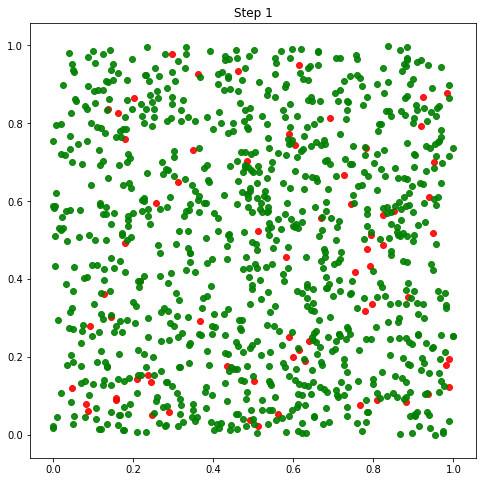

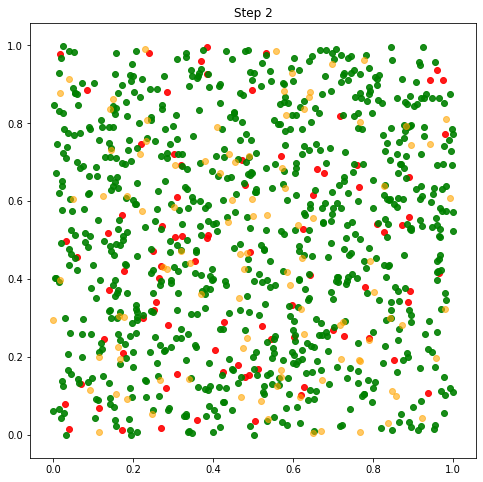

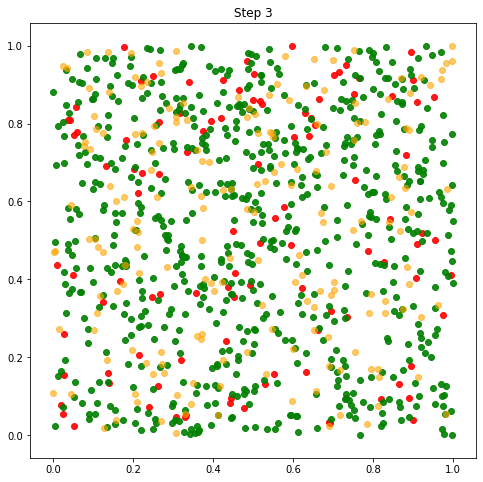

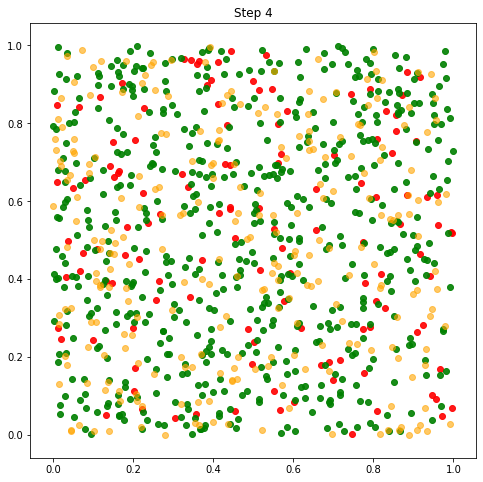

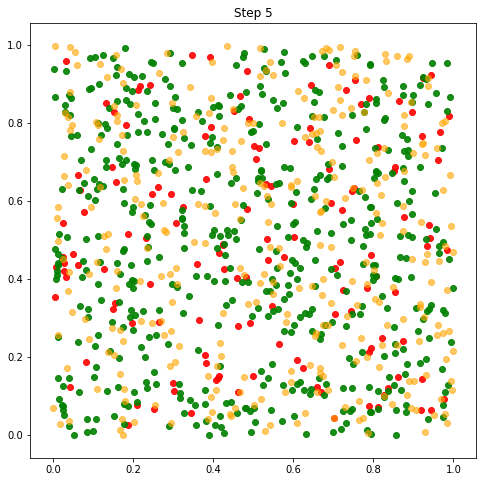

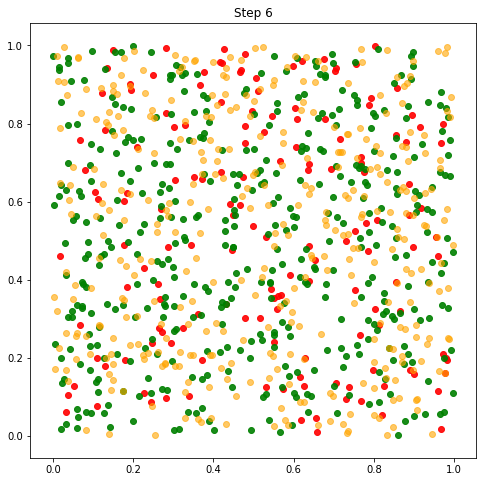

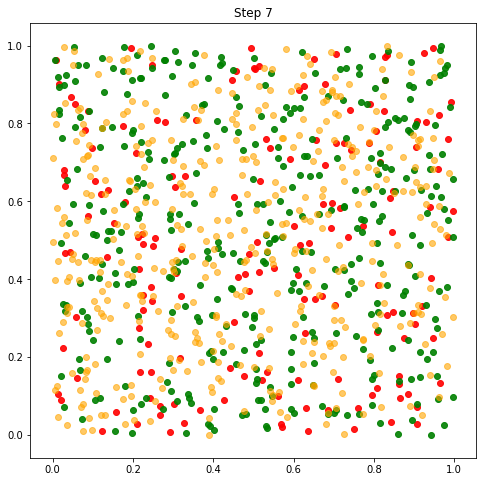

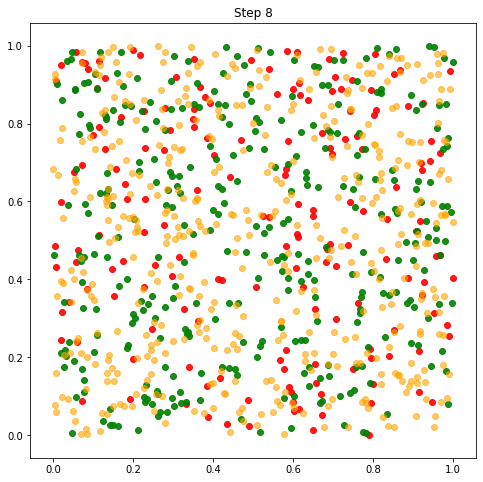

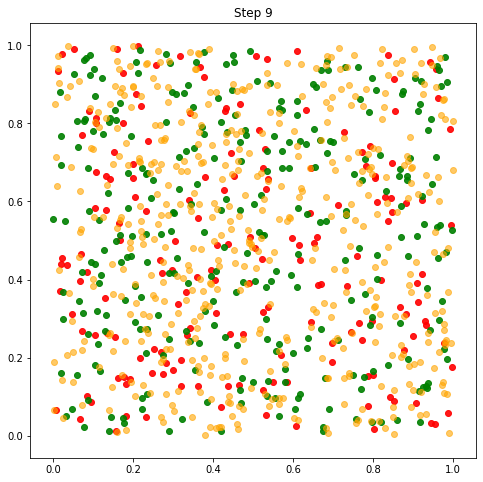

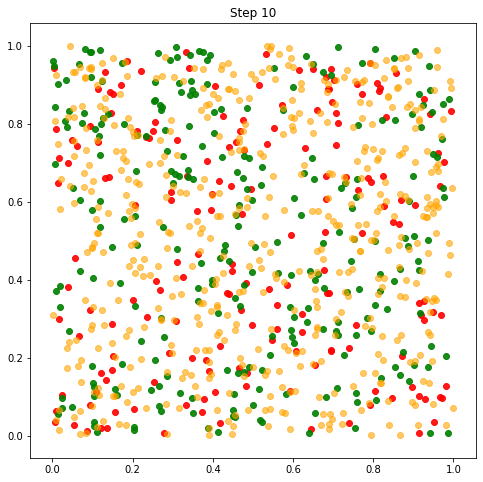

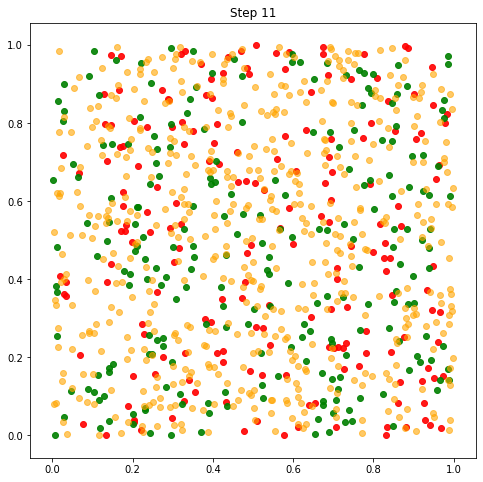

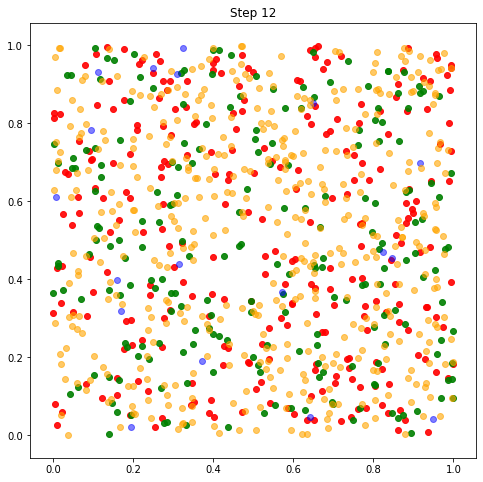

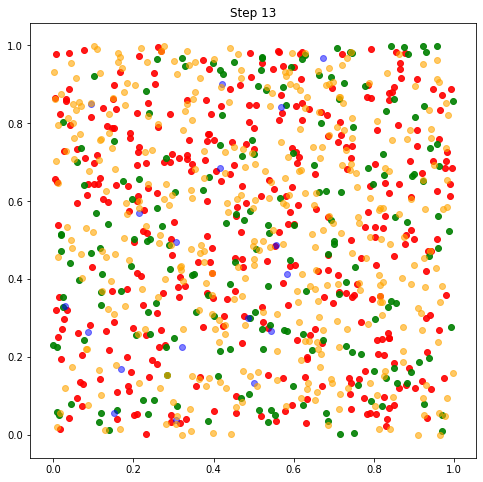

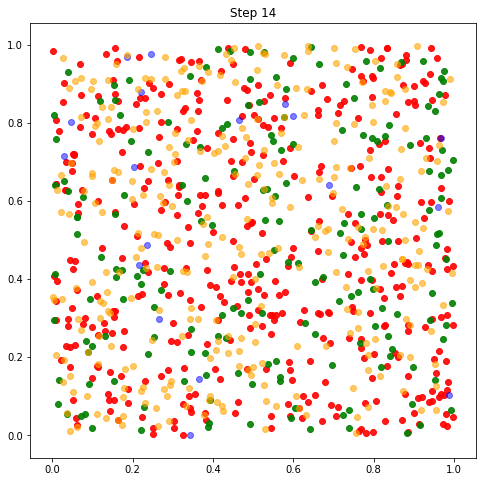

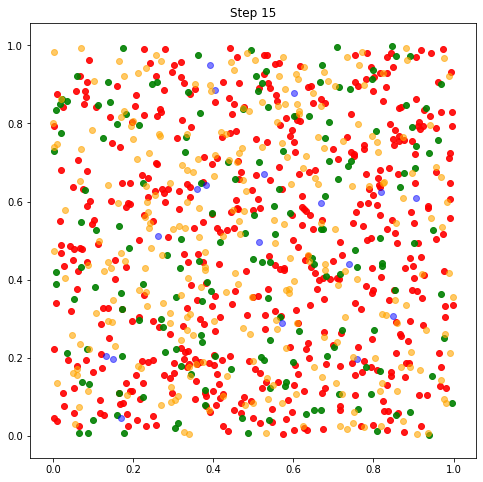

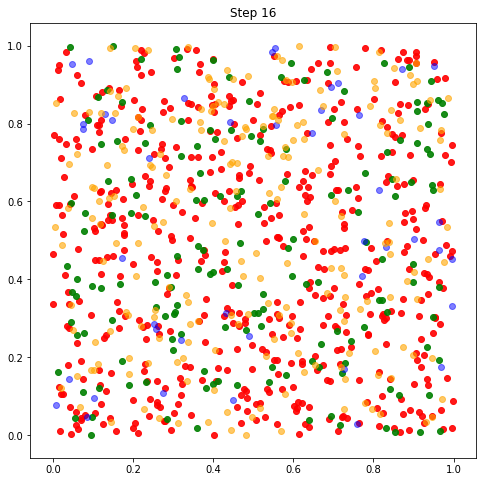

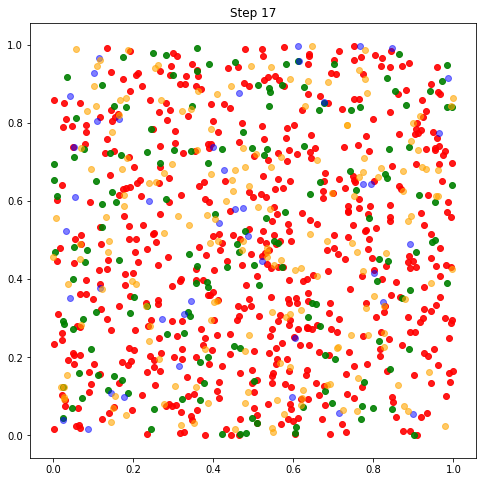

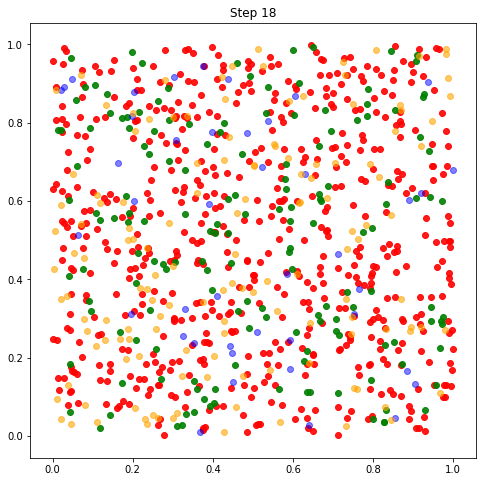

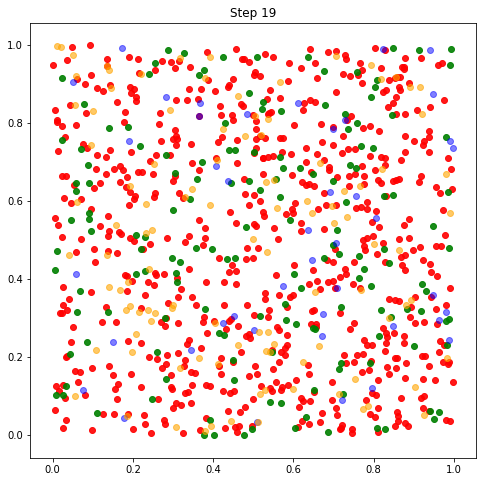

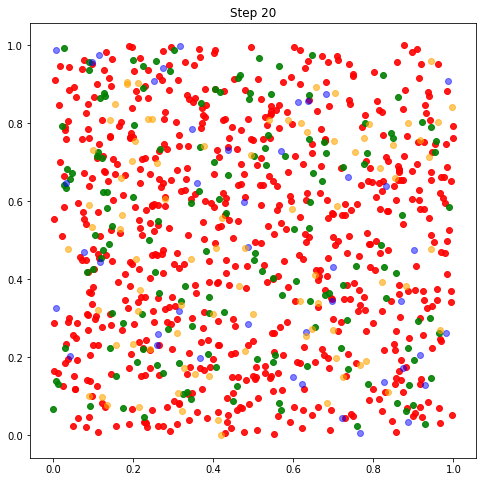

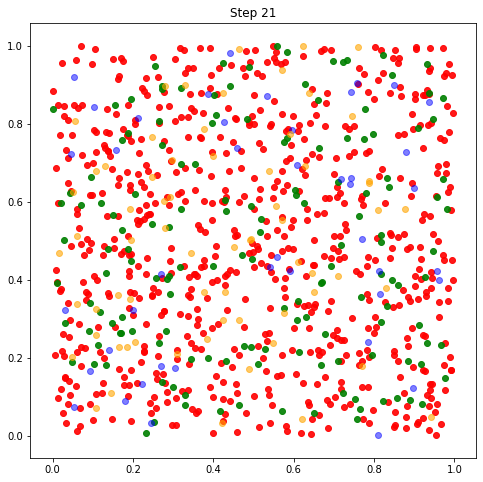

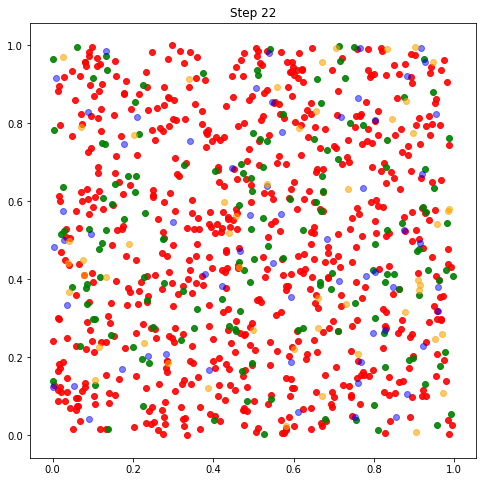

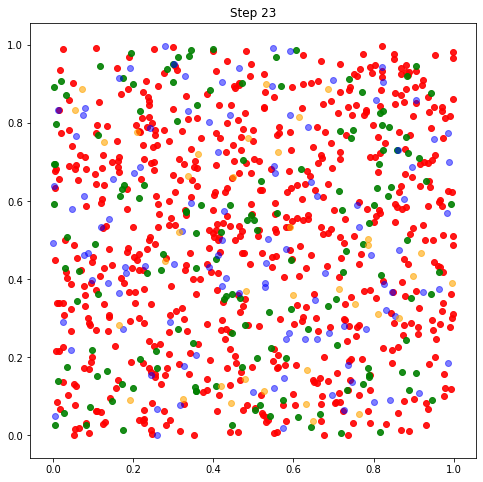

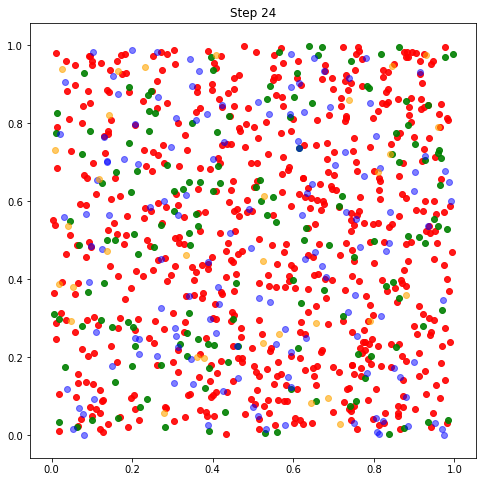

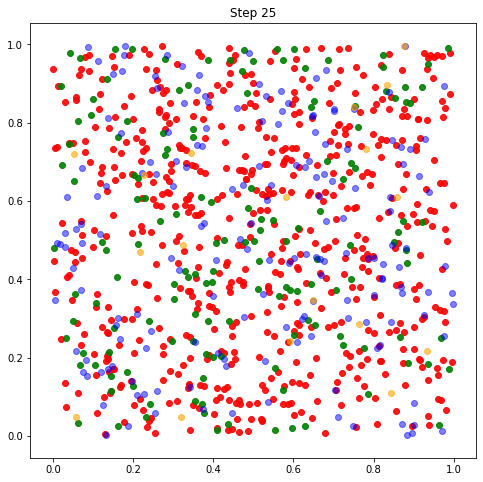

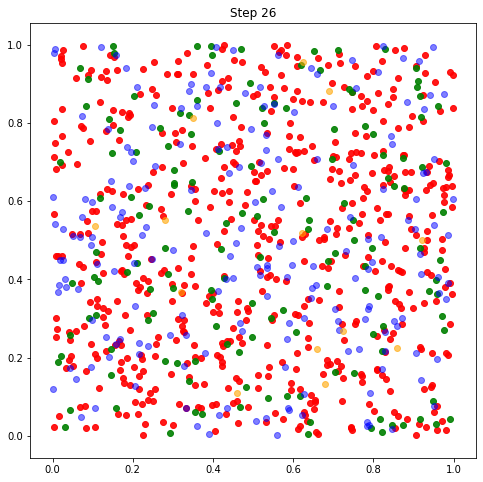

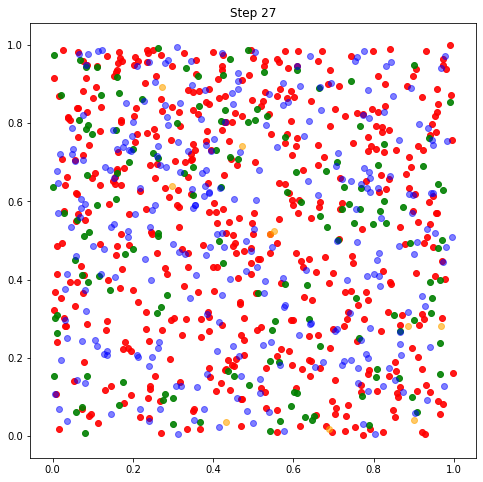

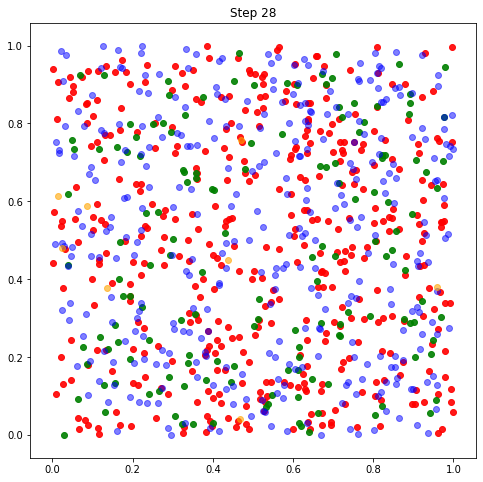

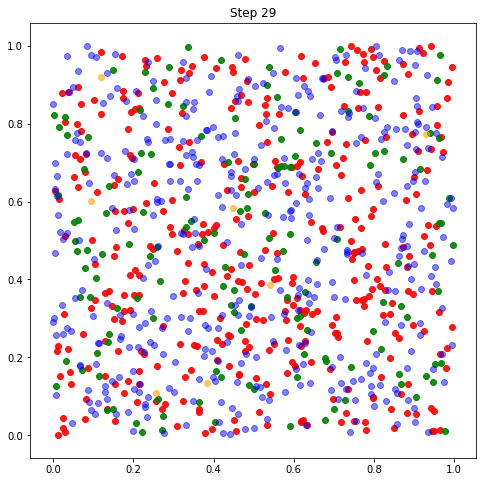

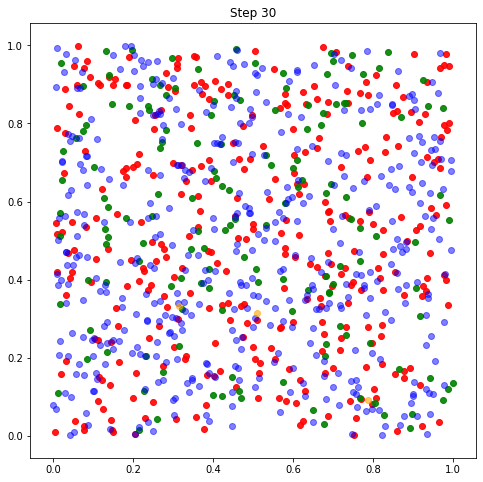

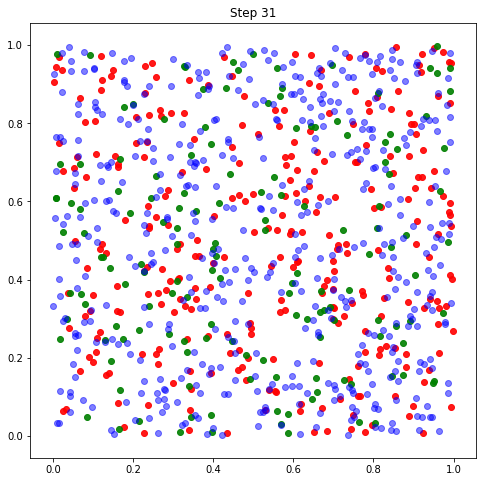

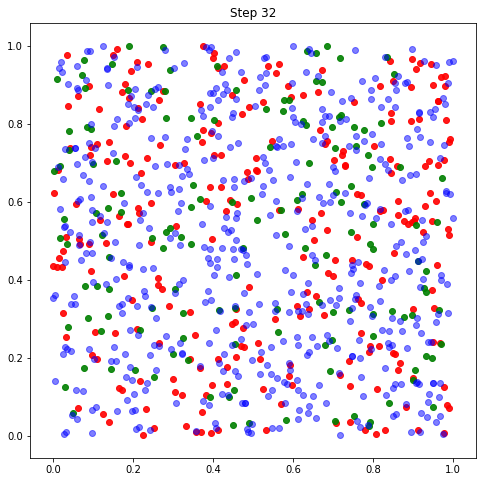

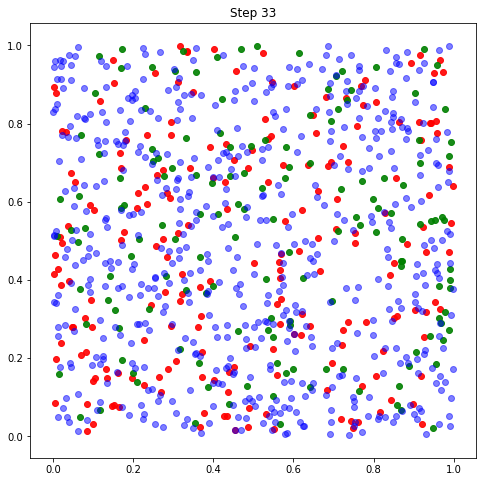

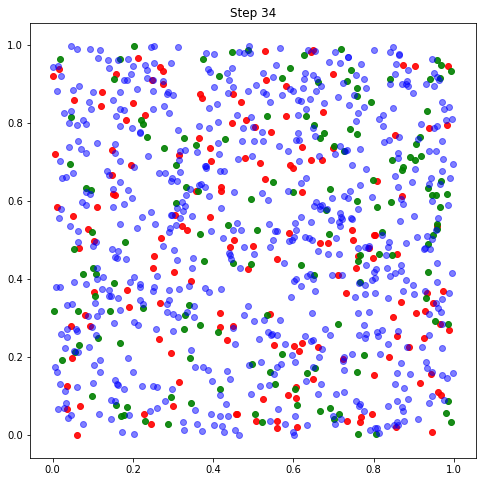

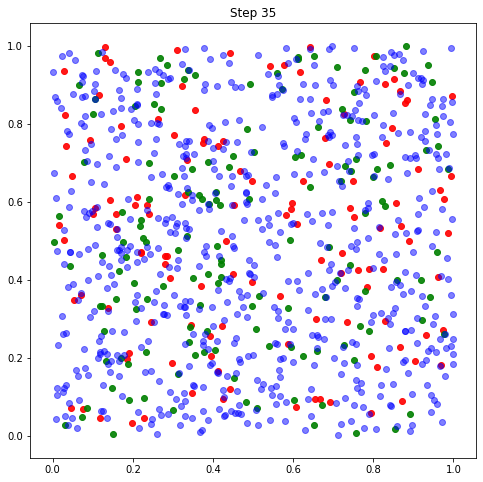

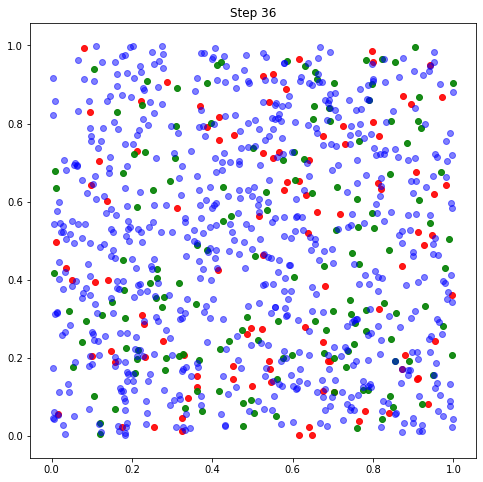

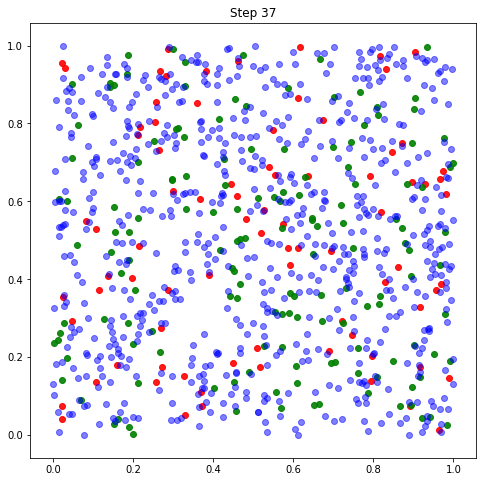

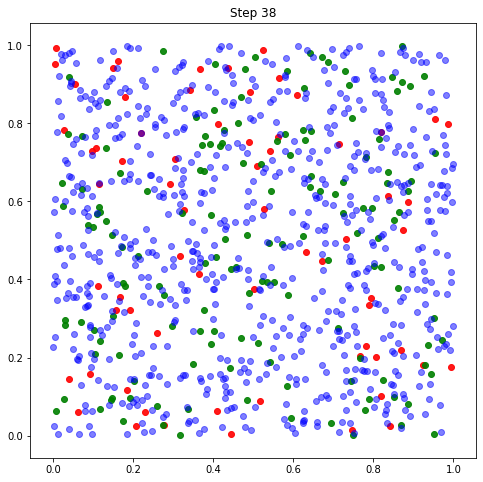

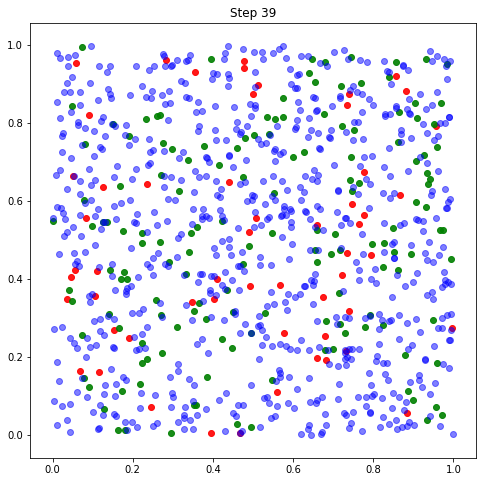

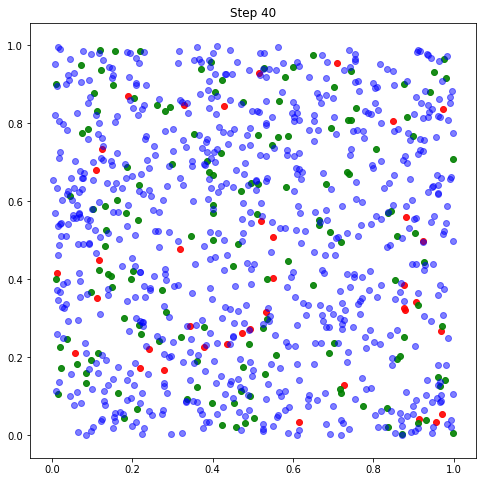

In [86]:
def plot_distribution(population, count):
    x_values_0, y_values_0 = [], []
    x_values_1, y_values_1 = [], []
    x_values_2, y_values_2 = [], []
    x_values_3, y_values_3 = [], []
    x_values_4, y_values_4 = [], []
    for agent in population:
        x, y = agent.location
        if agent.status.value == 'i':
            x_values_0.append(x)
            y_values_0.append(y)
        elif agent.status.value == 'h':
            x_values_1.append(x)
            y_values_1.append(y)
        elif agent.status.value == 's':
            x_values_2.append(x)
            y_values_2.append(y)
        elif agent.status.value == 'r':
            x_values_3.append(x)
            y_values_3.append(y)
        else:
            x_values_4.append(x)
            y_values_4.append(y)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_facecolor('white')
    ax.scatter(x_values_0, y_values_0, c='red', alpha=0.9)
    ax.scatter(x_values_1, y_values_1, c='green', alpha=0.9)
    ax.scatter(x_values_2, y_values_2, c='green', alpha=0.9)
    ax.scatter(x_values_3, y_values_3, c='blue', alpha=0.5)
    ax.scatter(x_values_4, y_values_4, c='orange', alpha=0.6)
    ax.set_title(f'Step {count}')
    plt.show()

count = 1
control = {'infected':[], 'healthy':[], 'recovered':[], 'exposed':[]}
infected = []
counts = []
while True:
    healthy = 0
    recovered = 0
    exposed = 0
    for agent in population:
        if agent.status.value == 'h' or agent.status.value == 's':
            healthy += 1
        if agent.status.value == 'i' and agent not in infected:
            infected.append(agent)
            counts.append(count)
        if agent.status.value == 'r':
            recovered += 1
        if agent.status.value == 'e':
            exposed += 1
    # control some variables        
    control['infected'].append(len(infected))
    control['healthy'].append(healthy)
    control['recovered'].append(recovered)
    control['exposed'].append(exposed)
    
    if len(infected) >= num_p.value*(num_inf.value-2)//100:
        plot_distribution(population, count)
        
        count += 1
        for _ in range(12):
            for agent in population:
                agent.move(delta.value, population, count, infected)
                agent.recovering(infected, counts, count, recovery_time.value)                   
                        
    else:
        break
#visualization with big contact rate  
plot_distribution(population, count)

## Wrapping up

In [87]:
num_p.value - len(population) #the number of deaths

73

In [88]:
print(f"The beginning number of infected: {num_p.value*num_inf.value//100}", f"\nAt the end: {len(infected)}")

The beginning number of infected: 70 
At the end: 47


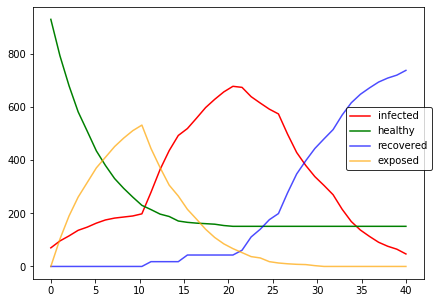

In [89]:
l1 = len(control['infected'])
l2 = len(control['healthy'])
l3 = len(control['recovered'])
l4 = len(control['exposed'])
x1 = np.linspace(0, l1, l1)
x2 = np.linspace(0, l2, l2)
x3 = np.linspace(0, l3, l3)
x4 = np.linspace(0, l4, l4)
fig1, ax1 = plt.subplots(figsize=(7,5))
ax1.plot(x1, control['infected'], c='r', label = 'infected')
ax1.plot(x2, control['healthy'], c='green', label='healthy')
ax1.plot(x3, control['recovered'], c='blue', alpha=0.7, label='recovered')
ax1.plot(x4, control['exposed'], c='orange', alpha=0.7, label='exposed')
ax1.legend(edgecolor='black', loc=(0.8,0.4))

In [90]:
#Creating families with own ids
num = 1
for child in age_categories['children']:
    child.family_status = 'id'+str(num)
    if age_categories['fathers'] != []:
        age_categories['fathers'][0].family_status = 'id'+str(num)
        age_categories['fathers'].pop(0)
    else:
        child.family_status = 'not in family'
        
    if age_categories['mothers'] != []:
        age_categories['mothers'][0].family_status = 'id'+str(num)
        age_categories['mothers'].pop(0)
    else:
        child.family_status = 'not in family'    
    num += 1

attributes = {'family':[], 'age':[], 'gender':[], 'location':[], 'status':[],\
              'immunity':[], 'job status':[], 'contacts':[]}
for agent in population:
    attributes['family'].append(agent.family_status)
    attributes['age'].append(agent.age)
    attributes['location'].append(agent.location)
    attributes['status'].append(agent.status.value)
    attributes['immunity'].append(agent.immunity)
    attributes['job status'].append(agent.job_status.value)
    attributes['contacts'].append(agent.k)
    attributes['gender'].append(agent.gender)
df = pd.DataFrame(attributes)

In [91]:
df = df.sort_values('family')
df

,family,age,gender,location,status,immunity,job status,contacts
0,id1,66,w,"(0.9634, 0.9612)",r,42.024195,rt,9
821,id1,70,m,"(0.1029, 0.7011)",r,18.562767,rt,2
439,id1,31,m,"(0.3826, 0.0344)",r,61.013046,w,23
882,id1,93,w,"(0.4705, 0.0141)",r,77.477331,rt,9
430,id1,57,w,"(0.5877, 0.0055)",r,46.984274,nw,16
...,...,...,...,...,...,...,...,...
646,not in family,12,m,"(0.6728, 0.4243)",r,75.102478,st,17
642,not in family,14,w,"(0.4421, 0.7748)",r,50.921283,st,26
343,not in family,3,m,"(0.9672, 0.1274)",s,42.286167,nst,13
655,not in family,14,w,"(0.0102, 0.9004)",s,92.804111,st,25


In [92]:
#you need install openpyxl
df.to_excel('population.xlsx')
df.to_csv('population.csv')